# Neuronal Anatomy Speaks: Can Cell Shape Whisper Sensory Preferences?

---
## Introduction
Tuning to preferred sensory stimuli is fundamental to our perception of the external world. This selective responsiveness of neurons to specific features of sensory input forms the basis of how our brain processes and interprets information from our environment. Traditionally, this tuning has been viewed as a purely functional characteristic, arising primarily from network-level properties and synaptic connections.

Neurons in the mammalian cortex, however, exhibit diverse morphologies, electrical compactness, and channel distributions, even within the same cell type. While these physical properties have often been overlooked in cortical studies, with most research focusing on network-level characteristics, they may play a crucial role in determining a neuron's response profile.

This project challenges the conventional approach by hypothesizing that the shape and intrinsic properties of neurons - specifically their electrical compactness and channel distributions - can predict their tuning to specific stimuli without the need for learning. By exploring this potential link between form and function, we aim to uncover whether a neuron's morphology could serve as a predictor of its sensory preferences, potentially reshaping our understanding of how sensory information is encoded at the cellular level.

### Objectives
1. Create simple models of cortical cells
2. Test the tuning of neuronal responses to different stimuli
3. Investigate the impact of varying input properties on neuronal responses
4. Produce summary figures of the results

### Methodology
1. Model Development:
   - Utilize this implementation of the Adaptive Exponential Integrate-and-Fire (AdEx) neuron model.
   - Create simple sinusoidal stimuli.

2. Parameter Exploration:
   - Design a loop to test ranges of parameters affecting electrical compactness and channel distributions.
   - Simulate neuronal responses to various stimuli across the parameter space.

3. Data Analysis:
   - Collect and organize simulation results.
   - Analyze the relationship between physical properties and neuronal tuning.

4. Visualization:
   - Create plots and summary figures to illustrate the findings.
   - Emphasize the correlation between neuronal properties and response tuning.

### Future Directions

The second part of the project will involve a more extensive study in close collaboration with experimental data analysis. This phase will build upon the findings of the initial computational exploration.


### Expected Outcomes and Significance

A computational framework for studying the impact of neuronal physical properties on stimulus tuning

Insights into the relationship between neuronal morphology, electrical compactness, channel distributions, and sensory response characteristics

Preliminary evidence supporting or refuting the hypothesis that a neuron's shape and intrinsic properties can predict its sensory preferences without learning

A foundation for future integrated computational and experimental studies in cortical neuroscience and sensory processing

This project aims to challenge conventional assumptions about cortical information processing and potentially reshape our understanding of how sensory information is encoded at the cellular level. By exploring the link between neuronal form and function, we may uncover a novel predictor of sensory preferences based on cellular morphology. This could have profound implications for both computational neuroscience and experimental research in cortical function and sensory perception.

If our hypothesis is supported, it would suggest that the brain's ability to process sensory information is not solely dependent on network-level properties, but also on the intrinsic characteristics of individual neurons. This could lead to new perspectives on neural development, sensory system organization, and even the evolution of sensory processing in the brain.

Furthermore, these findings could influence future approaches to studying sensory disorders, artificial neural networks, and brain-machine interfaces by highlighting the importance of considering cellular morphology in neural information processing.

---
## Methods

In [1]:
import csv
import os
from copy import deepcopy
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon

import scipy.linalg as linalg
from scipy.optimize import minimize
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

from sklearn.metrics import mean_squared_error

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

### Adaptive Exponential Integrate-and-Fire

The adaptive Exponential Integrate-and-Fire model (*AdEx* for short, introduced by [Brette and Gerstener (2005)](https://journals.physiology.org/doi/full/10.1152/jn.00686.2005), studied in [Touboul and Brette (2008)](https://link.springer.com/article/10.1007/s00422-008-0267-4), and characterized in [Naud et al. (2008)](https://link.springer.com/article/10.1007/s00422-008-0264-7)) describes the evolution of the membrane potential $V(t)$ of a single compartment of cell membrane. It consists of a system of two differential equations:

$$C{dV \over dt} = -g_L(V-E_L) + g_L\Delta_T exp({V-V_T \over \Delta_T}) +I - w$$
$$\tau_w{dw \over dt} = a(V-E_L)-w$$

When the potential goes beyond $V_T$, the exponential term generates an upswing of the membrane potential that mimics the fast activation of sodium channels in a Hodgkin–Huxley-type neuron model leading to initialtion of an action potential. 

At a spike detection threshold (fixed at 0 mV) a series of reset conditions is triggered:
$$
if \ V>0 \ mV \ then \begin{cases}
      V \to V_r\\
      w\to w_r = w+b\\
    \end{cases}
$$

The reset of the adaptation variable $w$ to its increment by a value $b$ leads to the accumulatation during a spike train.    
There are nine parameters required to define the evolution of the membrane potential ($V$) and the adaptation current ($w$), divided into *scaling parameters*:
- $C$, membrane capacitance
- $g_L$, leak conductance (often, the parameters $C$ and $g_L$ are absorbed into the time scale $\tau_m = C/gL$)
- $E_L$, leak equilibrium potential
- $\Delta_T$, exponential slope factor
- $V_T$, effective threshold potential

and *bifurcation parameters*:
- $a$, subthreshold adaptation conductance
- $b$, spike triggered adaptation
- $\tau_w$, adaptation time constant
- $V_r$, after-spike reset potential

Modifying the *bifurcation parameters* yields qualitative changes in the behavior of the system.

Here below, the two equations of the AdEx are expressed in code.

In [2]:
class AdExParameters:
    def __init__(self, gl, v_reset, a, b, tau_w, El, I, v_spike, tau_refrac, cm, delta_T, v_thresh):
        self.v_spike = v_spike
        self.tau_refrac = tau_refrac
        self.cm = cm
        self.gl = gl
        self.El = El
        self.delta_T = delta_T
        self.v_thresh = v_thresh
        self.v_reset = v_reset
        self.I = I
        self.a = a
        self.b = b
        self.tau_w = tau_w

def dVdt(V,w,p):
    return (-p.gl*(V -p.El) + p.gl*p.delta_T*np.exp((V - p.v_thresh) / p.delta_T) - w + p.I) / p.cm

def dwdt(V,w,p):
    return ( p.a*(V-p.El) -w ) / p.tau_w


We will use **phase plane analysis** to understand how cell parameters affect the AdEx dynamics (see [Touboul and Brette (2008)](https://link.springer.com/article/10.1007/s00422-008-0267-4) for a deeper view). In phase plane analysis we plot how the variables $V$ and $w$ change over time and relative to each other. 

To grasp the behavior of the system is often easier to study the relationships between the variables when they are slowly changing or fixed. To this end, we use **nullclines**. The nullcline for $V$ is the set of points where the rate of change of $V$ is zero ($dV/dt=0$). Similarly, the $w$-nullcline is the curve that represents all the points where $dw/dt=0$.

Here below, the nullclines are expressed as functions to be later evaluated.

In [3]:
def V_nullcline(V,p):
    return (-p.gl*(V - p.El) + p.gl*p.delta_T*np.exp((V - p.v_thresh)/p.delta_T) + p.I) / p.cm

def w_nullcline(V,p):
    return p.a * (V-p.El)

# function to assign linearly spaced points to the nullcline
def nullcline(f, params, limits, steps):
    fn = []
    c = np.linspace( limits[0], limits[1], steps ) # linearly spaced numbers
    for i in c:
        fn.append( f(i,params) )
    return c, fn

The intersection of the two nullclines defines **fixed points**. In the AdEx model, a fixed point corresponds to a specific combination of membrane potential (V) and adaptation current (w) at which both derivatives (dV/dt and dw/dt) are zero.

The stability of fixed points is given by the eigenvalues of the linearized matrix. If all eigenvalues have negative real parts, the fixed point is stable (attracting). If any eigenvalue has a positive real part, the fixed point is unstable (repelling). If there are both positive and negative eigenvalues, it's a saddle point, and the stability depends on the specific eigenvalues.

In [4]:
# Function to find the fixed points
def find_fixed_points(f1, f2, params):
    # Function to solve for dVdt and dwdt
    def adex_eq(state):
        x,y = state
        return [f1(x,y,params), f2(x,y,params)]

    # Use fsolve to find the fixed points
    fixed_points = []
    initial_guesses = [(params.El, 0), (params.v_thresh, 0)]  # Initial guesses for the fixed points

    for guess in initial_guesses:
        V, w = fsolve(adex_eq, guess) # find the zeros
        alreadyExisting = False
        for fp in fixed_points:
            if np.all(np.isclose([V, w], fp, rtol=1e-5)):
                alreadyExisting = True
        if not alreadyExisting:
            fixed_points.append([V, w])

    return fixed_points


# Perform stability analysis for each fixed point
def stability_analysis(f1, f2, p):
    fixed_points = find_fixed_points(f1, f2, p)
            
    for i, (Vfix, wfix) in enumerate(fixed_points):
        # Jacobian matrix (linearized equations)
        J = np.array([
            [-p.gl/p.cm +(p.gl*p.delta_T*np.exp((Vfix-p.v_thresh)/p.delta_T))/p.cm, -1/p.cm],
            [p.a/p.tau_w, -1/p.tau_w]
        ])

        # Compute eigenvalues
        eigenvalues, _ = np.linalg.eig(J)

        # Print the results
        print(f"Fixed Point {i+1}: V = {Vfix:.4f}, w = {wfix:.4f}")
        print("Eigenvalues:", eigenvalues)
        if np.all(np.real(eigenvalues) < 0):
            print("Stability: Stable (attracting)")
        elif np.all(np.real(eigenvalues) > 0):
            print("Stability: Unstable (repelling)")
        else:
            print("Stability: Saddle point")
        print()

Here we use the Euler integration method, for its simplicity and didactic value (over precision, better achieved with other methods, such as Runge-Kutta).

In [5]:
# f1, f2 = function for each variable, iv = initial vector, dt = timestep, time = range
def Euler( f1, f2, params, iv, dt, time, withTransition=False, timeDivider=7, stimDuration=4.3):
    x = np.zeros(time)
    y = np.zeros(time)
    # initial values:
    x[0] = iv[0] # Vm
    y[0] = iv[1] # w
    # compute and fill lists
    i=1
    I = params.I
    while i < time:
        if withTransition:
            params.I = 0 # init
            if i > time/timeDivider and i < stimDuration*(time/timeDivider):
                params.I = I #

        # integrating
        x[i] = x[i-1] + ( f1(x[i-1],y[i-1],params) )*dt
        y[i] = y[i-1] + ( f2(x[i-1],y[i-1],params) )*dt

        # discontinuity
        if x[i] >= params.v_spike:
            x[i-1] = params.v_spike
            x[i] = params.v_reset
            y[i] = y[i] + params.b
            # refractory period
            refractory_steps = int(params.tau_refrac / dt) # refrac is in ms already
            for j in range(refractory_steps): 
                if i+j < time:
                    x[i+j] = params.v_reset
                    if j == 0:
                        y[i + j] = y[i]          # Increment y only once
                    else:
                        y[i + j] = y[i + j - 1]  # Hold y steady
            i += refractory_steps - 1

        i += 1 # iterate

    return x, y

Additional functions for plotting

In [6]:
# interpolation function to plot data and simulations on the same panel
def increase_temporal_resolution(time_series, new_time_interval):
    timestamps, values = zip(*time_series)
    timestamps = np.array(timestamps)
    values = np.array(values)
    min_timestamp = min(timestamps)
    max_timestamp = max(timestamps)
    new_timestamps = np.arange(min_timestamp, max_timestamp + new_time_interval, new_time_interval)
    interp_function = interp1d(timestamps, values, kind='linear', fill_value='extrapolate')
    new_values = interp_function(new_timestamps)
    new_time_series = list(zip(new_timestamps, new_values))
    return new_time_series

def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

Functions to ease plotting

In [7]:
def quiverplot( exe, f1, f2, p, limits, grid_step, ax ):
    # define a grid and compute direction at each point
    x = np.linspace( limits[0][0], limits[0][1], grid_step)
    y = np.linspace( limits[1][0], limits[1][1], grid_step)
    X1 , Y1  = np.meshgrid(x, y) # create grid
    DX1 = X1.copy()
    DY1 = Y1.copy()
    for j in range(len(y)):
        for i in range(len(x)):
            x1, y1 = exe( f1, f2, p, (x[i],y[j]), 0.01, 2) # compute 1 step growth
            # print(x1, y1)
            DX1[j][i] = x1[1]-x1[0]
            DY1[j][i] = y1[1]-y1[0]
    M = (np.hypot(DX1, DY1))
    ax.quiver(X1, Y1, DX1, DY1, color='lightgray', pivot='mid', units='xy')

def plotFigure(params, x, y, xn1, xn2, yn1, yn2, xn1Ip, xn2Ip, fp, withZoom=False, color='black', outfile=None, axes=[-90,-35,-1.50,1.50], Time=None, dt=None):
    fig, axs = plt.subplots(2, 2, figsize=(15,5))
    time = np.arange(0, Time * dt, dt)
    axs[0,0].plot(time, x, '-', color=color, label='Vm')
    axs[1,0].plot(time, y, 'b-', label='w')
    axs[0,0].set_ylabel("Potential V (mV)")
    axs[1,0].set_ylabel("Adaptation w (nA)")
    axs[1,0].set_xlabel("time (ms)")
    axs[0,0].set_title("Dynamics in time")

    axi = plt.gca()
    plt.draw()
    #labels = axs[0,0].get_xticklabels()
    #for i,label in enumerate(labels):
    #    labels[i] = "{:d}".format(int(i*dt))
    #axs[0,0].set_xticklabels(labels)
    axs[0,0].legend()

    #labels = axs[1,0].get_xticklabels()
    #for i,label in enumerate(labels):
    #    labels[i] = "{:d}".format(int(i*dt))
    #axs[1,0].set_xticklabels(labels)
    axs[1,0].legend()    

    ax_phase_plane = fig.add_subplot(1, 2, 2)
    ax_phase_plane.axis(axes)
    ax_phase_plane.plot(x, y, color=color)
    ax_phase_plane.plot(xn1, xn2, '-', color=color)
    ax_phase_plane.plot(xn1Ip, xn2Ip, '--',color=color)
    ax_phase_plane.plot(yn1, yn2, color="blue")
    for p in fp:
        ax_phase_plane.plot(p[0], p[1], color='green', marker='o', markersize=5)
    quiverplot( Euler, dVdt, dwdt, params, [(axes[0],axes[1]),(axes[2],axes[3])], 10, ax_phase_plane ) #
    ax_phase_plane.set_xlabel("V (mV)")
    ax_phase_plane.set_ylabel("w (pA)")
    ax_phase_plane.set_title("Phase plane")

    # Trick to hide the empty subplot
    fig.delaxes(axs[0, 1])
    fig.delaxes(axs[1, 1])
    
    plt.show()
    if outfile:
        fig.savefig(outfile, transparent=True, dpi=500)
        plt.close()
        fig.clear()
        fig.clf()

Container functions, shorthand for repeated operations:

In [8]:
def phase(dVdt, dwdt, params, init, dt, Time, withTransition=True, timeDivider=7, stimDuration=4.3, axes=[-90,-25,-1,1], outfile='./default.svg'):
    I = params.I
    x, y = Euler( dVdt, dwdt, params, init, dt, Time, withTransition=True, timeDivider=timeDivider, stimDuration=stimDuration )

    # print("a/gl =",params.a/params.gl)
    # print("tau_m/tau_w =",(params.cm/params.gl)/params.tau_w)
    # ExcClass = "A"
    # if params.a/params.gl > (params.cm/params.gl)/params.tau_w:
    #     ExcClass = "B"
    # print("The system is of excitability class",ExcClass)
    # print()

    # to draw the field
    fp = find_fixed_points(dVdt, dwdt, params) # iterations

    # Perform stability analysis
    stability_analysis(dVdt, dwdt, params)

    xn1Ip, xn2Ip = nullcline( V_nullcline, params, axes[0:2], 100 )
    params.I = I
    xn1, xn2 = nullcline( V_nullcline, params, axes[0:2], 100 )
    yn1, yn2 = nullcline( w_nullcline, params, axes[0:2], 100 )

    plotFigure(params, x, y, xn1, xn2, yn1, yn2, xn1Ip, xn2Ip, fp, color='k', outfile=outfile, axes=axes, Time=Time, dt=dt)

---
#### Cortical Regular Spiking cell

Based on 65 published articles on cortical pyramidal cells, the aggregator [neuroelectro](https://www.neuroelectro.org/neuron/110/) provides reference values for several parameters.

For the remaining parameters, we kept the initial values proposed by [Destexhe 2009](https://pubmed.ncbi.nlm.nih.gov/19499317/).

In [80]:
PY_control = AdExParameters(
    v_spike = 10.0,   # mV, spike detection
    tau_refrac = 2.5, # ms, refractory period (https://www.neuroelectro.org/neuron/110/)
    cm = 0.170,       # nF, tot membrane capacitance (https://www.neuroelectro.org/neuron/110/)
    gl = 0.01,        # uS, leak conductance
    El = -78.0,       # mV, resting potential
    delta_T = 2.5,    # mV, steepness of exponential approach to threshold (Destexhe2009)
    v_thresh = -60.0, # mV, spike threshold (Metherate et al. 1992)
    v_reset = -61.0,  # mV, reset after spike
    I = 0.0,          # nA, Input current 
    a = 0.01,         # µS, conductance of voltage coupling
    b = 0.08,        # nA, increment to spike-triggered adaptation
    tau_w = 260.0     # ms, time constant of adaptation variable
)
params = PY_control

Fixed Point 1: V = -77.9991, w = 0.0000
Eigenvalues: [-0.05422262 -0.00833723]
Stability: Stable (attracting)



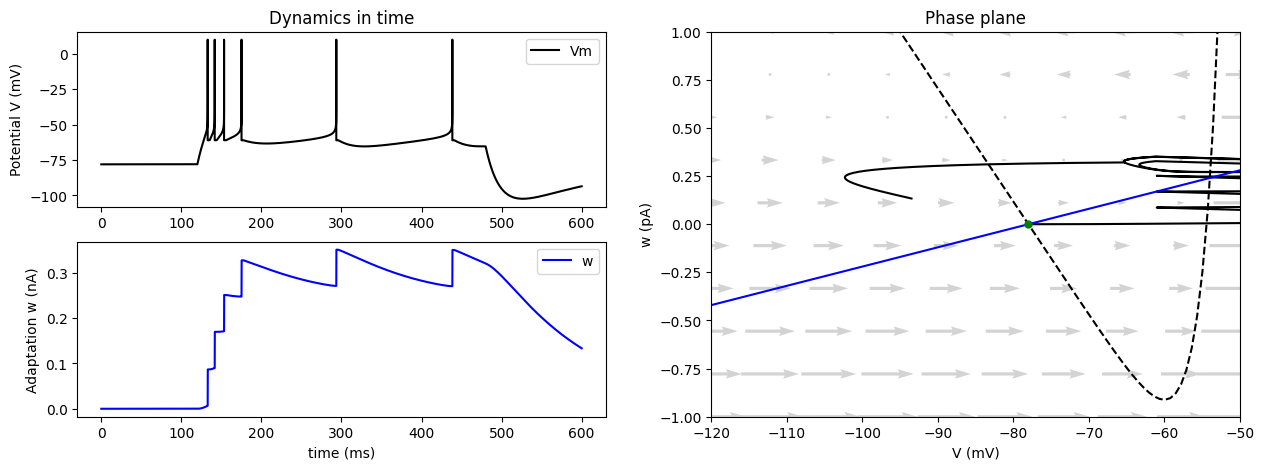

In [81]:
# dynamic
Time = 60000
dt = 0.01 # ms
init = (params.El, 0)
params.I = .45 # nA

phase(dVdt, dwdt, params, init, dt, Time, 
      withTransition=True, timeDivider=5, stimDuration=4,
      axes=[-120,-50,-1,1], outfile='./Py.svg')

The function above is a shorthand for the following code

[-78.         -77.97352831 -77.94707219 ... -57.00544025 -57.00243895
 -56.99943342]


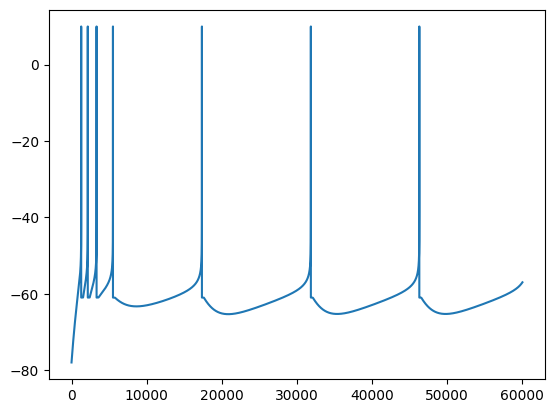

In [82]:
Vm,w = Euler( dVdt, dwdt, params, init, dt, Time, withTransition=False)
print(Vm)

# which you can simply plot with ...
fig, ax = plt.subplots()
ax.plot(np.arange(Time), Vm)

---
### Sinusoidal input

The first task is to modify the Euler function above to accept a sinusoidal stimulus.

This can be done in many ways. The simplest is to allow the parameter params.I to be an array...

In [83]:
# Here your code to implement different types of input...
cycles = 2 # how many sine cycles
resolution = 25 # how many datapoints to generate

length = np.pi * 2 * cycles
sininputs = np.sin(np.arange(0, length, length / resolution))
print(sininputs)

[ 0.          0.48175367  0.84432793  0.99802673  0.90482705  0.58778525
  0.12533323 -0.36812455 -0.77051324 -0.98228725 -0.95105652 -0.68454711
 -0.24868989  0.24868989  0.68454711  0.95105652  0.98228725  0.77051324
  0.36812455 -0.12533323 -0.58778525 -0.90482705 -0.99802673 -0.84432793
 -0.48175367]


---
#### Parameter search


In this simple yet dynamically rich setup, several parameters can be used as proxy for the passive effects of cell shape.
On the aggregator [neuroelectro](https://www.neuroelectro.org/neuron/110/) we find several of them:

**Cell capacitance** (C), goes from .076 nF to .336 nF

**Membrane time constant** (C/gl): from 1.6 ms to 76.8 ms

These two parameters can be a good starting point for a search.

In [89]:
# Define the grid for parameter values
C_values = np.linspace(0.076, 0.336, 15)
gl_values = np.linspace(0.01, 0.1, 15)

# Create an empty array to store the simulation results
PY_mean_Vm = np.zeros( (len(gl_values), len(C_values)) )
PY_mean_spike_count = np.zeros( (len(gl_values), len(C_values)) )

# execution
params = deepcopy(PY_control)
init = (params.El, 0.0)  # Initial guess for V (mV) and w
dt = 0.01  # Time step for integration (ms)
params.I = .5 # nA
time = 10000 # ms

# Loop over parameter combinations and compute MAE
for i, gl in enumerate(gl_values):
    for j, C in enumerate(C_values):
        # Simulate the AdEx model for the current parameter combination
        params.gl = gl
        params.cm = C
        # params.I = sininputs ... takes an array
        Vm,w = Euler( dVdt, dwdt, params, init, dt, time, withTransition=False)
        # we can start with a simple mean mambrane potential
        PY_mean_Vm[i, j] = np.mean(Vm)
        # evaluate how many times there is a spike
        # ... you can check how many times the Vm reaches params.v_spikes

print(PY_mean_Vm)
print(PY_mean_spike_count)

[[-62.233533   -61.8537127  -61.40538339 -60.90805497 -60.40880462
  -59.93820461 -59.5328615  -59.21829916 -59.01165151 -59.25226654
  -59.42773304 -59.51359936 -59.55109565 -59.55570482 -59.53057595]
 [-61.8339773  -61.03386657 -60.27320722 -59.9212758  -60.32958891
  -60.49522284 -60.5937004  -60.65132725 -60.68369688 -60.68981038
  -60.68024401 -60.65836507 -60.61915517 -60.57725271 -60.52329056]
 [-62.10058901 -62.11515997 -62.12091248 -62.11582097 -62.10144734
  -62.07550377 -62.03798754 -61.99104776 -61.93239248 -61.86560933
  -61.78784688 -61.7034615  -61.61065039 -61.51522899 -61.41391475]
 [-63.30376148 -63.27936348 -63.24776863 -63.20693169 -63.15283662
  -63.08788308 -63.00930152 -62.91310651 -62.79695554 -62.65917679
  -62.49371732 -62.30147882 -62.07669942 -61.8246398  -61.57101638]
 [-64.47006348 -64.53817324 -64.6064752  -64.67497492 -64.74367809
  -64.81259052 -64.88171811 -64.95106671 -65.02064183 -65.0904482
  -65.16048916 -65.23076601 -65.30127743 -65.37201892 -65.4

In [85]:
np.save("PY_mean_Vm.npy", PY_mean_Vm)

[0.01, 0.17]


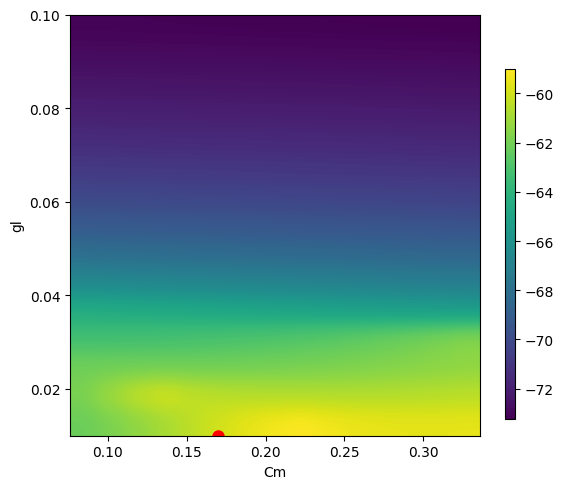

In [91]:
# list of all parameter ranges
param_ranges = [gl_values, C_values]

# parameter set
params = deepcopy(PY_control)
hparams = [params.gl, params.cm]
print(hparams)

# combinations of all 2D heatmaps
combinations = [(i, j) for i in range(2) for j in range(i+1, 2)]
num_plots = len(combinations)
num_rows = 3
num_cols = 5
fig = plt.figure(figsize=(5, 5))

heatmaps = []
hlabels = ['gl', 'Cm']
for idx, (dim1_idx, dim2_idx) in enumerate(combinations):
    # fix two dimensions and take the minimum MAE over the others
    min_mae_fixed_dims = np.min(PY_mean_Vm, axis=tuple(set(range(2)) - {dim1_idx, dim2_idx}))
    # subplot access
    dim1_label = hlabels[dim1_idx]
    dim2_label = hlabels[dim2_idx]
    ax = fig.add_subplot()
    heatmap = ax.imshow(min_mae_fixed_dims, origin='lower',
                          extent=[param_ranges[dim2_idx][0], param_ranges[dim2_idx][-1],
                                  param_ranges[dim1_idx][0], param_ranges[dim1_idx][-1]],
                          interpolation='gaussian', aspect='auto', cmap='viridis')
    ax.set_xlabel(dim2_label)
    ax.set_ylabel(dim1_label)
    heatmaps.append(heatmap)

    # dot at the original parameter set's coordinates
    ax.plot(hparams[dim2_idx], hparams[dim1_idx], 'ro', markersize=8)

    # indices of the minimum MAE
    min_idx_dim1, min_idx_dim2 = np.unravel_index(np.argmin(min_mae_fixed_dims), min_mae_fixed_dims.shape)
    # corresponding gl and Cm values
    min_gl = param_ranges[dim2_idx][min_idx_dim2]
    min_El = param_ranges[dim1_idx][min_idx_dim1]

# single colorbar for all the heatmaps
cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7]) # left, bottom, width, height
cbar = fig.colorbar(heatmaps[0], cax=cbar_ax)
plt.tight_layout()
plt.show()
fig.savefig('./PY_Control.svg', transparent=True, dpi=500)
plt.close()
fig.clear()
fig.clf()